## This notebook will implement number of experiments on the normal and anomaly data using Kolmogorov-Smirnov Test (KS Test)

Datasets:

| **Normal** | **Anomaly**                                                    |
|------------|----------------------------------------------------------------|
| building   | laser_fault/building                                           |
| cans       | laser_fault/cans, obstacle/cans                                |
| corr       | laser_fault/corr, obstacle/corr                                |
| pick       | pick/miss_cup, pick/restricted_vision, pick/stolen, pick/stuck |
| -          | software_fault                                                 |
| -          | velocity_attack                                                |

Cans - map name
Corr - map name

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

In the first experiment, we will test anomaly detection on building navigation. The normal data contains regular navigation in the environment. The anomaly contains various navigation scenarios and problems while navigation like obstacles, faults of the components, etc.

In [5]:
# Consts
INF=0
SUP=200

In [6]:
def load_directory(directory, file_prefix):
    runs = []
    for i in range(len(os.listdir(directory))):
        f = os.path.join(directory, file_prefix + str(i + 1) + ".csv")
        if os.path.isfile(f):
            runs.append(np.genfromtxt(f, delimiter=",", skip_header=1))
    return runs, np.concatenate([np.reshape(r, -1) for r in runs])

def plot_hist(runs, title):
    fig, axs = plt.subplots(1)
    for i, r in enumerate(runs):
        axs.hist(np.reshape(r[np.logical_and(r>INF, r<SUP)], -1), bins='auto', density=True)
    axs.set_title(title)
    axs.set_xlim((INF,SUP))
    
def ks_test(runs, more_runs=[]):
    ks_test = []
    if len(more_runs) == 0: # Compare to itself
        for j, rj in enumerate(runs):
            other_runs = np.concatenate([np.reshape(runs[i], -1) for i in range(len(runs)) if i != j])
            ks_test.append(ks_2samp(np.reshape(other_runs, -1), np.reshape(rj, -1)).statistic)
    else: # Compare to other
        n = 2
        for j, rj in enumerate(runs):
            rj = rj[len(rj)*(n-2)//3:]
            ks_test.append(ks_2samp(np.reshape(more_runs, -1), np.reshape(rj, -1)).statistic)
    return ks_test

def plot_ks_test_results(norm_norm, norm_anomaly, anomaly_anomaly, title=''):
    plt.title(title)
    plt.hist(ks_normal_normal, bins="auto", density=True, alpha=0.5, label='normal vs normal')
    plt.hist(ks_normal_anomaly, bins="auto", density=True, alpha=0.5, label='anomaly vs normal')
    plt.hist(ks_anomaly_anomaly, bins="auto", density=True, alpha=0.5, label='anomaly vs anomaly')
    plt.legend()

# Laser Fault

## Loading building and laser faults data

```data/normal/building/counts_normal_build*.csv```

```data/anomaly/laser_fault/building/counts_laser_fault_build*.csv```

In [99]:
TITLE_NORMAL = 'Building normal'
TITLE_ANOMALY = 'Building with laser fault'
NORM_COUNTS_PATH = './data/normal/building'
NORM_FILE_PREFIX = 'counts_normal_build'
ANOMALY_COUNTS_PATH = './data/anomaly/laser_fault/building'
ANOM_FILE_PREFIX = 'counts_laser_fault_build'

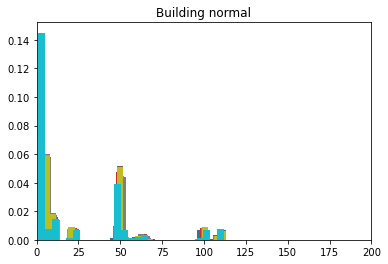

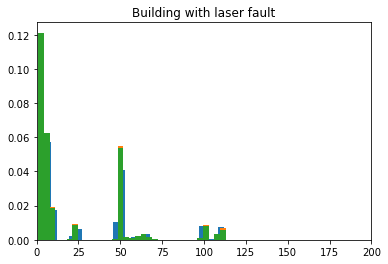

In [100]:
runs, all_runs = load_directory(NORM_COUNTS_PATH, NORM_FILE_PREFIX)
plot_hist(runs, TITLE_NORMAL)

anomaly_runs, all_anomaly_runs = load_directory(ANOMALY_COUNTS_PATH, ANOM_FILE_PREFIX)
plot_hist(anomaly_runs, TITLE_ANOMALY)

### Laser fault KS Test

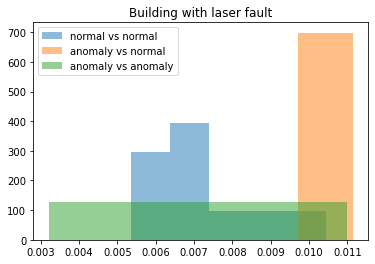

In [101]:
ks_normal_normal = ks_test(runs)
ks_normal_anomaly = ks_test(anomaly_runs, all_runs)
ks_anomaly_anomaly = ks_test(anomaly_runs)
plot_ks_test_results(ks_normal_normal, ks_normal_anomaly, ks_anomaly_anomaly, TITLE_ANOMALY)

# Software fault

## Loading building and software faults data

```data/normal/building/counts_normal_build*.csv```

```data/anomaly/software_fault/counts_software_fault_*.csv```

In [102]:
TITLE_NORMAL = 'Building normal'
TITLE_ANOMALY = 'Building with  software fault'
NORM_COUNTS_PATH = './data/normal/building'
NORM_FILE_PREFIX = 'counts_normal_build'
ANOMALY_COUNTS_PATH = './data/anomaly/software_fault'
ANOM_FILE_PREFIX = 'counts_software_fault_'

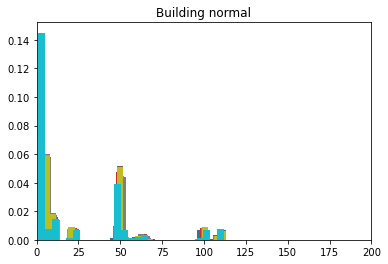

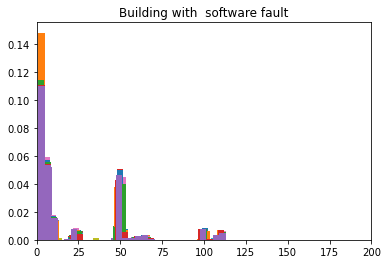

In [103]:
runs, all_runs = load_directory(NORM_COUNTS_PATH, NORM_FILE_PREFIX)
plot_hist(runs, TITLE_NORMAL)
anomaly_runs, all_anomaly_runs = load_directory(ANOMALY_COUNTS_PATH, ANOM_FILE_PREFIX)
plot_hist(anomaly_runs, TITLE_ANOMALY)

### Software fault KS Test

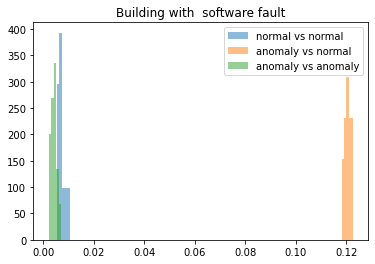

In [104]:
ks_normal_normal = ks_test(runs)
ks_normal_anomaly = ks_test(anomaly_runs, all_runs)
ks_anomaly_anomaly = ks_test(anomaly_runs)
plot_ks_test_results(ks_normal_normal, ks_normal_anomaly, ks_anomaly_anomaly, TITLE_ANOMALY)

# Velocity attack

## Loading building and velocity attack data

```data/normal/building/counts_normal_build*.csv```

```data/anomaly/velocity_attack/counts_velocity_attack_*.csv```

In [105]:
TITLE_NORMAL = 'Building normal'
TITLE_ANOMALY = 'Building with velocity attack'
NORM_COUNTS_PATH = './data/normal/building'
NORM_FILE_PREFIX = 'counts_normal_build'
ANOMALY_COUNTS_PATH = './data/anomaly/velocity_attack'
ANOM_FILE_PREFIX = 'counts_velocity_attack_'

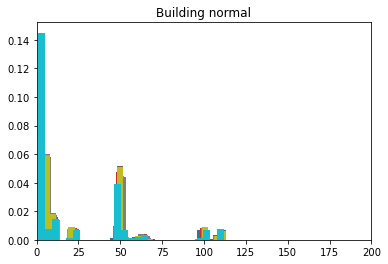

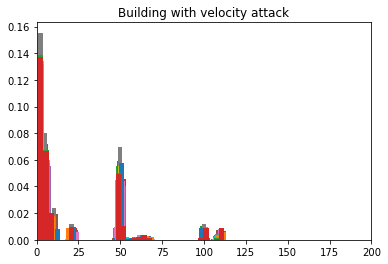

In [106]:
runs, all_runs = load_directory(NORM_COUNTS_PATH, NORM_FILE_PREFIX)
plot_hist(runs, TITLE_NORMAL)

anomaly_runs, all_anomaly_runs = load_directory(ANOMALY_COUNTS_PATH, ANOM_FILE_PREFIX)
plot_hist(anomaly_runs, TITLE_ANOMALY)

### Velocity attack KS Test

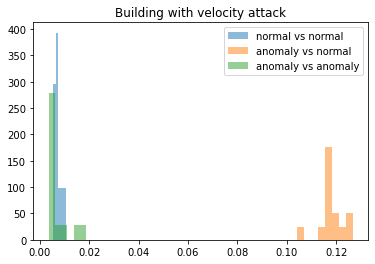

In [107]:
ks_normal_normal = ks_test(runs)
ks_normal_anomaly = ks_test(anomaly_runs, all_runs)
ks_anomaly_anomaly = ks_test(anomaly_runs)
plot_ks_test_results(ks_normal_normal, ks_normal_anomaly, ks_anomaly_anomaly, TITLE_ANOMALY)

# Cans Laser fault

## Loading Cans and Laser fault data

```data/normal/cans/counts_normal_cans*.csv```

```data/anomaly/laser_fault/cans/counts_laser_fault_cans*.csv```

In [108]:
TITLE_NORMAL = 'Cans normal'
TITLE_ANOMALY = 'Cans with Laser fault'
NORM_COUNTS_PATH = './data/normal/cans'
NORM_FILE_PREFIX = 'counts_normal_cans'
ANOMALY_COUNTS_PATH = './data/anomaly/laser_fault/cans'
ANOM_FILE_PREFIX = 'counts_laser_fault_cans'

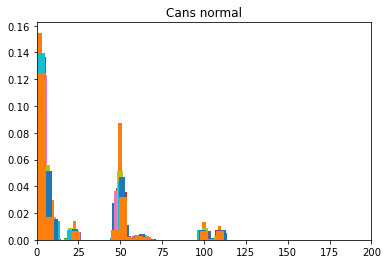

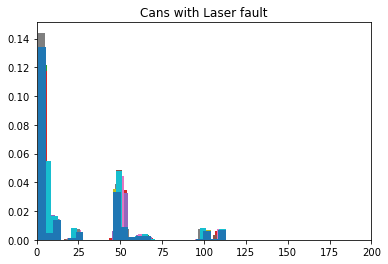

In [109]:
runs, all_runs = load_directory(NORM_COUNTS_PATH, NORM_FILE_PREFIX)
plot_hist(runs, TITLE_NORMAL)

anomaly_runs, all_anomaly_runs = load_directory(ANOMALY_COUNTS_PATH, ANOM_FILE_PREFIX)
plot_hist(anomaly_runs, TITLE_ANOMALY)

### Cans Laser fault KS Test

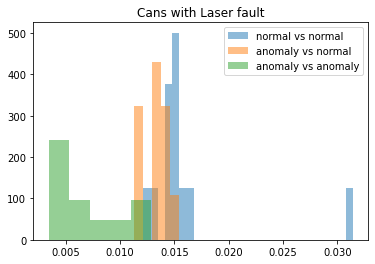

In [110]:
ks_normal_normal = ks_test(runs)
ks_normal_anomaly = ks_test(anomaly_runs, all_runs)
ks_anomaly_anomaly = ks_test(anomaly_runs)
plot_ks_test_results(ks_normal_normal, ks_normal_anomaly, ks_anomaly_anomaly, TITLE_ANOMALY)

# Cans Obstacles

## Loading Cans and Obstacles data

```data/normal/cans/counts_normal_cans*.csv```

```data/anomaly/obstacle/cans/counts_laser_fault_cans*.csv```

In [111]:
TITLE_NORMAL = 'Cans normal'
TITLE_ANOMALY = 'Cans with Obstacles'
NORM_COUNTS_PATH = './data/normal/cans'
NORM_FILE_PREFIX = 'counts_normal_cans'
ANOMALY_COUNTS_PATH = './data/anomaly/obstacle/cans'
ANOM_FILE_PREFIX = 'counts_obs_cans'

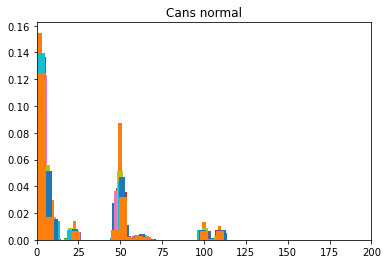

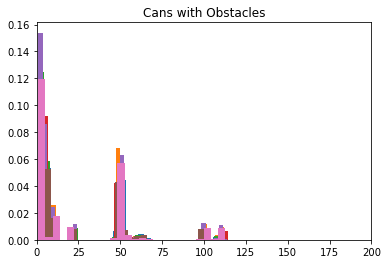

In [112]:
runs, all_runs = load_directory(NORM_COUNTS_PATH, NORM_FILE_PREFIX)
plot_hist(runs, TITLE_NORMAL)

anomaly_runs, all_anomaly_runs = load_directory(ANOMALY_COUNTS_PATH, ANOM_FILE_PREFIX)
plot_hist(anomaly_runs, TITLE_ANOMALY)

### Cans Obstacle KS Test

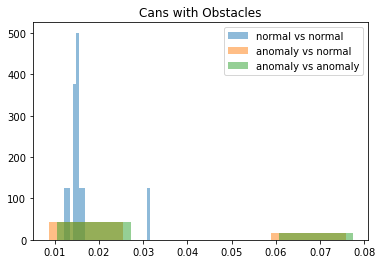

In [113]:
ks_normal_normal = ks_test(runs)
ks_normal_anomaly = ks_test(anomaly_runs, all_runs)
ks_anomaly_anomaly = ks_test(anomaly_runs)
plot_ks_test_results(ks_normal_normal, ks_normal_anomaly, ks_anomaly_anomaly, TITLE_ANOMALY)

# Corr Laser fault

## Loading Corr and Laser fault data

```data/normal/corr/counts_normal_corr_rand*.csv```

```data/anomaly/laser_fault/corr/counts_laser_fault_corr_rand*.csv```

In [114]:
TITLE_NORMAL = 'Corr normal'
TITLE_ANOMALY = 'Corr with Laser fault'
NORM_COUNTS_PATH = './data/normal/corr'
NORM_FILE_PREFIX = 'counts_normal_corr_rand'
ANOMALY_COUNTS_PATH = './data/anomaly/laser_fault/corr'
ANOM_FILE_PREFIX = 'counts_laser_fault_corr_rand'

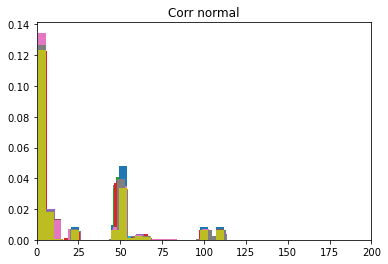

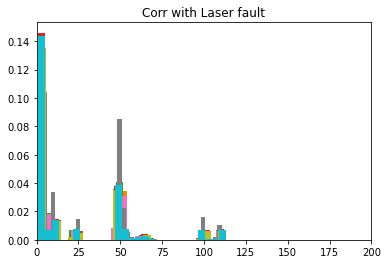

In [115]:
runs, all_runs = load_directory(NORM_COUNTS_PATH, NORM_FILE_PREFIX)
plot_hist(runs, TITLE_NORMAL)

anomaly_runs, all_anomaly_runs = load_directory(ANOMALY_COUNTS_PATH, ANOM_FILE_PREFIX)
plot_hist(anomaly_runs, TITLE_ANOMALY)

### Corr Laser fault KS Test

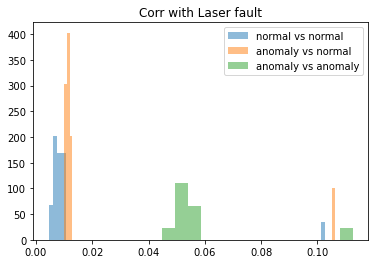

In [116]:
ks_normal_normal = ks_test(runs)
ks_normal_anomaly = ks_test(anomaly_runs, all_runs)
ks_anomaly_anomaly = ks_test(anomaly_runs)
plot_ks_test_results(ks_normal_normal, ks_normal_anomaly, ks_anomaly_anomaly, TITLE_ANOMALY)

# Corr Obstacles

## Loading Corr and Obstacles data

```data/normal/corr/counts_normal_corr_rand*.csv```

```data/anomaly/obstacle/corr/counts_laser_fault_cans*.csv```

In [117]:
TITLE_NORMAL = 'Corr normal'
TITLE_ANOMALY = 'Corr with Obstacles'
NORM_COUNTS_PATH = './data/normal/corr'
NORM_FILE_PREFIX = 'counts_normal_corr_rand'
ANOMALY_COUNTS_PATH = './data/anomaly/obstacle/corr'
ANOM_FILE_PREFIX = 'counts_obs_corr_rand'

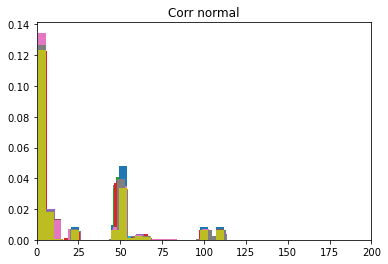

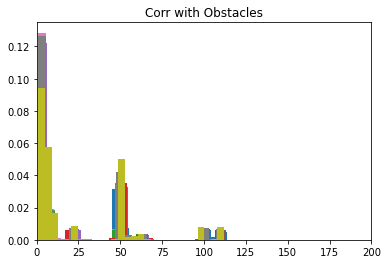

In [118]:
runs, all_runs = load_directory(NORM_COUNTS_PATH, NORM_FILE_PREFIX)
plot_hist(runs, TITLE_NORMAL)

anomaly_runs, all_anomaly_runs = load_directory(ANOMALY_COUNTS_PATH, ANOM_FILE_PREFIX)
plot_hist(anomaly_runs, TITLE_ANOMALY)

### Corr Obstacle KS Test

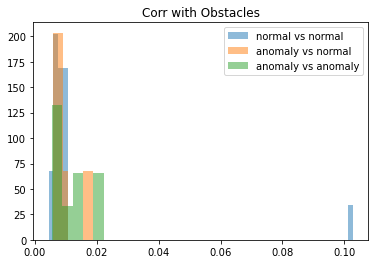

In [119]:
ks_normal_normal = ks_test(runs)
ks_normal_anomaly = ks_test(anomaly_runs, all_runs)
ks_anomaly_anomaly = ks_test(anomaly_runs)
plot_ks_test_results(ks_normal_normal, ks_normal_anomaly, ks_anomaly_anomaly, TITLE_ANOMALY)

# Pick and miss cup

## Loading pick and miss cup data

```data/normal/pick/pick_normal*.csv```

```data/anomaly/pick/miss_cup/counts_miss_cup*.csv```

In [17]:
TITLE_NORMAL = 'Pick normal'
TITLE_ANOMALY = 'Pick and miss cup'
NORM_COUNTS_PATH = './data/normal/pick'
NORM_FILE_PREFIX = 'pick_normal'
ANOMALY_COUNTS_PATH = './data/anomaly/pick/miss_cup'
ANOM_FILE_PREFIX = 'counts_miss_cup'

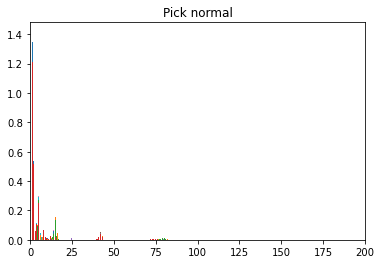

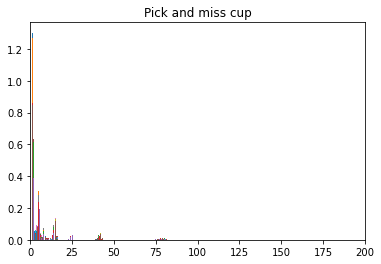

In [18]:
runs, all_runs = load_directory(NORM_COUNTS_PATH, NORM_FILE_PREFIX)
plot_hist(runs, TITLE_NORMAL)

anomaly_runs, all_anomaly_runs = load_directory(ANOMALY_COUNTS_PATH, ANOM_FILE_PREFIX)
plot_hist(anomaly_runs, TITLE_ANOMALY)

### Pick and miss cup KS Test

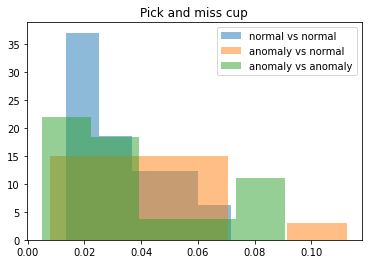

In [19]:
ks_normal_normal = ks_test(runs)
ks_normal_anomaly = ks_test(anomaly_runs, all_runs)
ks_anomaly_anomaly = ks_test(anomaly_runs)
plot_ks_test_results(ks_normal_normal, ks_normal_anomaly, ks_anomaly_anomaly, TITLE_ANOMALY)

# Pick and restricted vision

## Loading pick and restricted vision data

```data/normal/pick/pick_normal*.csv```

```data/anomaly/pick/restricted_vision/counts_restricted_vision*.csv```

In [7]:
TITLE_NORMAL = 'Pick normal'
TITLE_ANOMALY = 'Pick and restricted vision'
NORM_COUNTS_PATH = './data/normal/pick'
NORM_FILE_PREFIX = 'pick_normal'
ANOMALY_COUNTS_PATH = './data/anomaly/pick/restricted_vision'
ANOM_FILE_PREFIX = 'counts_restricted_vision'

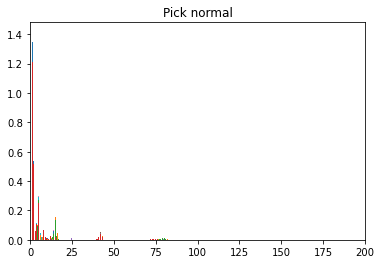

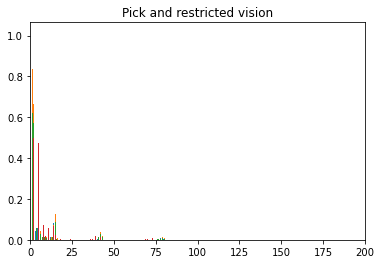

In [8]:
runs, all_runs = load_directory(NORM_COUNTS_PATH, NORM_FILE_PREFIX)
plot_hist(runs, TITLE_NORMAL)

anomaly_runs, all_anomaly_runs = load_directory(ANOMALY_COUNTS_PATH, ANOM_FILE_PREFIX)
plot_hist(anomaly_runs, TITLE_ANOMALY)

### Pick and restricted vision KS Test

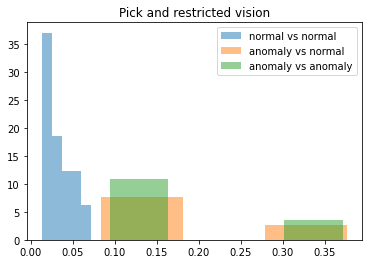

In [9]:
ks_normal_normal = ks_test(runs)
ks_normal_anomaly = ks_test(anomaly_runs, all_runs)
ks_anomaly_anomaly = ks_test(anomaly_runs)
plot_ks_test_results(ks_normal_normal, ks_normal_anomaly, ks_anomaly_anomaly, TITLE_ANOMALY)

# Pick and stolen cup

## Loading pick and stolen cup data

```data/normal/pick/pick_normal*.csv```

```data/anomaly/pick/stolen/counts_cup_stolen*.csv```

In [10]:
TITLE_NORMAL = 'Pick normal'
TITLE_ANOMALY = 'Pick and stolen'
NORM_COUNTS_PATH = './data/normal/pick'
NORM_FILE_PREFIX = 'pick_normal'
ANOMALY_COUNTS_PATH = './data/anomaly/pick/stolen'
ANOM_FILE_PREFIX = 'counts_cup_stolen'

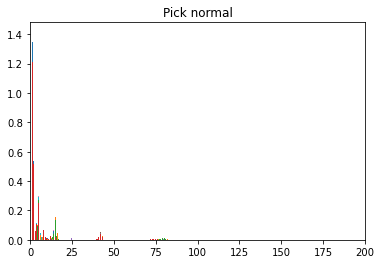

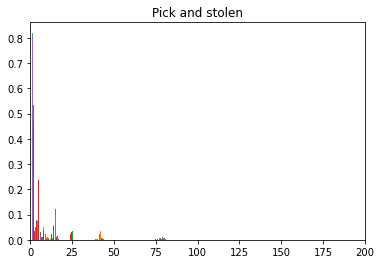

In [11]:
runs, all_runs = load_directory(NORM_COUNTS_PATH, NORM_FILE_PREFIX)
plot_hist(runs, TITLE_NORMAL)

anomaly_runs, all_anomaly_runs = load_directory(ANOMALY_COUNTS_PATH, ANOM_FILE_PREFIX)
plot_hist(anomaly_runs, TITLE_ANOMALY)

### Pick and stolen cup KS Test

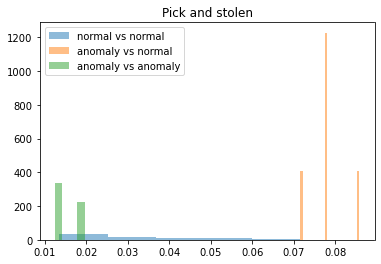

In [12]:
ks_normal_normal = ks_test(runs)
ks_normal_anomaly = ks_test(anomaly_runs, all_runs)
ks_anomaly_anomaly = ks_test(anomaly_runs)
plot_ks_test_results(ks_normal_normal, ks_normal_anomaly, ks_anomaly_anomaly, TITLE_ANOMALY)

# Pick and stuck

## Loading pick and stuck data

```data/normal/pick/pick_normal*.csv```

```data/anomaly/pick/stuck/counts_got_stuck*.csv```

In [13]:
TITLE_NORMAL = 'Pick normal'
TITLE_ANOMALY = 'Pick and stuck'
NORM_COUNTS_PATH = './data/normal/pick'
NORM_FILE_PREFIX = 'pick_normal'
ANOMALY_COUNTS_PATH = './data/anomaly/pick/stuck'
ANOM_FILE_PREFIX = 'counts_got_stuck'

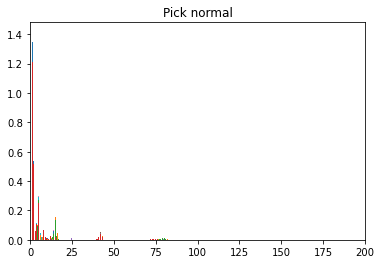

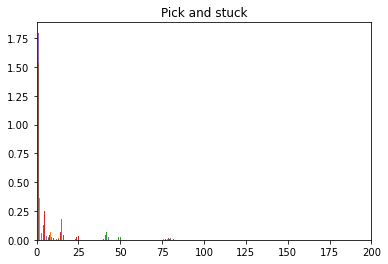

In [14]:
runs, all_runs = load_directory(NORM_COUNTS_PATH, NORM_FILE_PREFIX)
plot_hist(runs, TITLE_NORMAL)

anomaly_runs, all_anomaly_runs = load_directory(ANOMALY_COUNTS_PATH, ANOM_FILE_PREFIX)
plot_hist(anomaly_runs, TITLE_ANOMALY)

### Pick and stuck KS Test

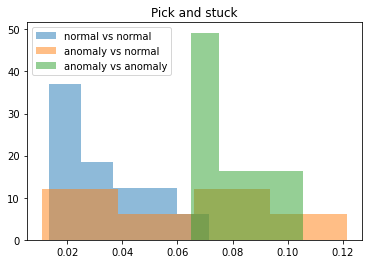

In [15]:
ks_normal_normal = ks_test(runs)
ks_normal_anomaly = ks_test(anomaly_runs, all_runs)
ks_anomaly_anomaly = ks_test(anomaly_runs)
plot_ks_test_results(ks_normal_normal, ks_normal_anomaly, ks_anomaly_anomaly, TITLE_ANOMALY)